In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from tabulate import tabulate

In [2]:
# Load the dataset
df = pd.read_csv("ResidentialEnergyConsumption.csv")
df = df[df['Value'] != 'Not Available']

for index, value in df['YYYYMM'].items():
    value_str = str(value)
    if value_str[-2:] == '13':
        df.drop(index, inplace=True)

print(tabulate(df.head(), headers='keys', tablefmt='psql', showindex=False))

+---------+----------+---------+----------------+-----------------------------------------+--------------+
| MSN     |   YYYYMM |   Value |   Column_Order | Description                             | Unit         |
|---------+----------+---------+----------------+-----------------------------------------+--------------|
| CLRCBUS |   197301 |  11.894 |              1 | Coal Consumed by the Residential Sector | Trillion Btu |
| CLRCBUS |   197302 |  10.188 |              1 | Coal Consumed by the Residential Sector | Trillion Btu |
| CLRCBUS |   197303 |   8     |              1 | Coal Consumed by the Residential Sector | Trillion Btu |
| CLRCBUS |   197304 |   5.237 |              1 | Coal Consumed by the Residential Sector | Trillion Btu |
| CLRCBUS |   197305 |   5.313 |              1 | Coal Consumed by the Residential Sector | Trillion Btu |
+---------+----------+---------+----------------+-----------------------------------------+--------------+


In [3]:
df = df[df['Description'] == 'Total Energy Consumed by the Residential Sector']

In [4]:
# Check for duplicate entries in the 'Date' column
duplicates = df['YYYYMM'].duplicated()

# Print rows with duplicate dates
print(df[duplicates])

Empty DataFrame
Columns: [MSN, YYYYMM, Value, Column_Order, Description, Unit]
Index: []


In [5]:
# Function to transform the YYYYMM format
def transform_date(date):
    date_str = str(date)
    year = date_str[:4]
    month = date_str[4:]
    return f"{year}-{month}-01"

# Apply the transformation to the column
df['Transformed'] = df['YYYYMM'].apply(transform_date)

# Convert 'YYYYMM' column to datetime format without specifying the format explicitly
df['Date'] = pd.to_datetime(df['Transformed'])

dataset = df.drop(columns=['YYYYMM', 'Transformed'])

#print(dataset['Date'].dtype)

In [6]:
# Print the first 5 rows of the modified DataFrame without the time component in the 'Date' column
print("First 5 rows of the modified DataFrame:")
print(tabulate(dataset.head(), headers='keys', tablefmt='psql', showindex=False))

First 5 rows of the modified DataFrame:
+---------+----------+----------------+-------------------------------------------------+--------------+---------------------+
| MSN     |    Value |   Column_Order | Description                                     | Unit         | Date                |
|---------+----------+----------------+-------------------------------------------------+--------------+---------------------|
| TERCBUS | 1891.12  |             13 | Total Energy Consumed by the Residential Sector | Trillion Btu | 1973-01-01 00:00:00 |
| TERCBUS | 1654.72  |             13 | Total Energy Consumed by the Residential Sector | Trillion Btu | 1973-02-01 00:00:00 |
| TERCBUS | 1449.52  |             13 | Total Energy Consumed by the Residential Sector | Trillion Btu | 1973-03-01 00:00:00 |
| TERCBUS | 1129.6   |             13 | Total Energy Consumed by the Residential Sector | Trillion Btu | 1973-04-01 00:00:00 |
| TERCBUS |  953.556 |             13 | Total Energy Consumed by the Re

8280    1891.117
8281    1654.718
8282    1449.521
8283    1129.600
8284     953.556
          ...   
8938    1303.581
8939    1212.222
8940    1522.505
8941    1869.076
8943    2396.794
Name: Value, Length: 613, dtype: float64


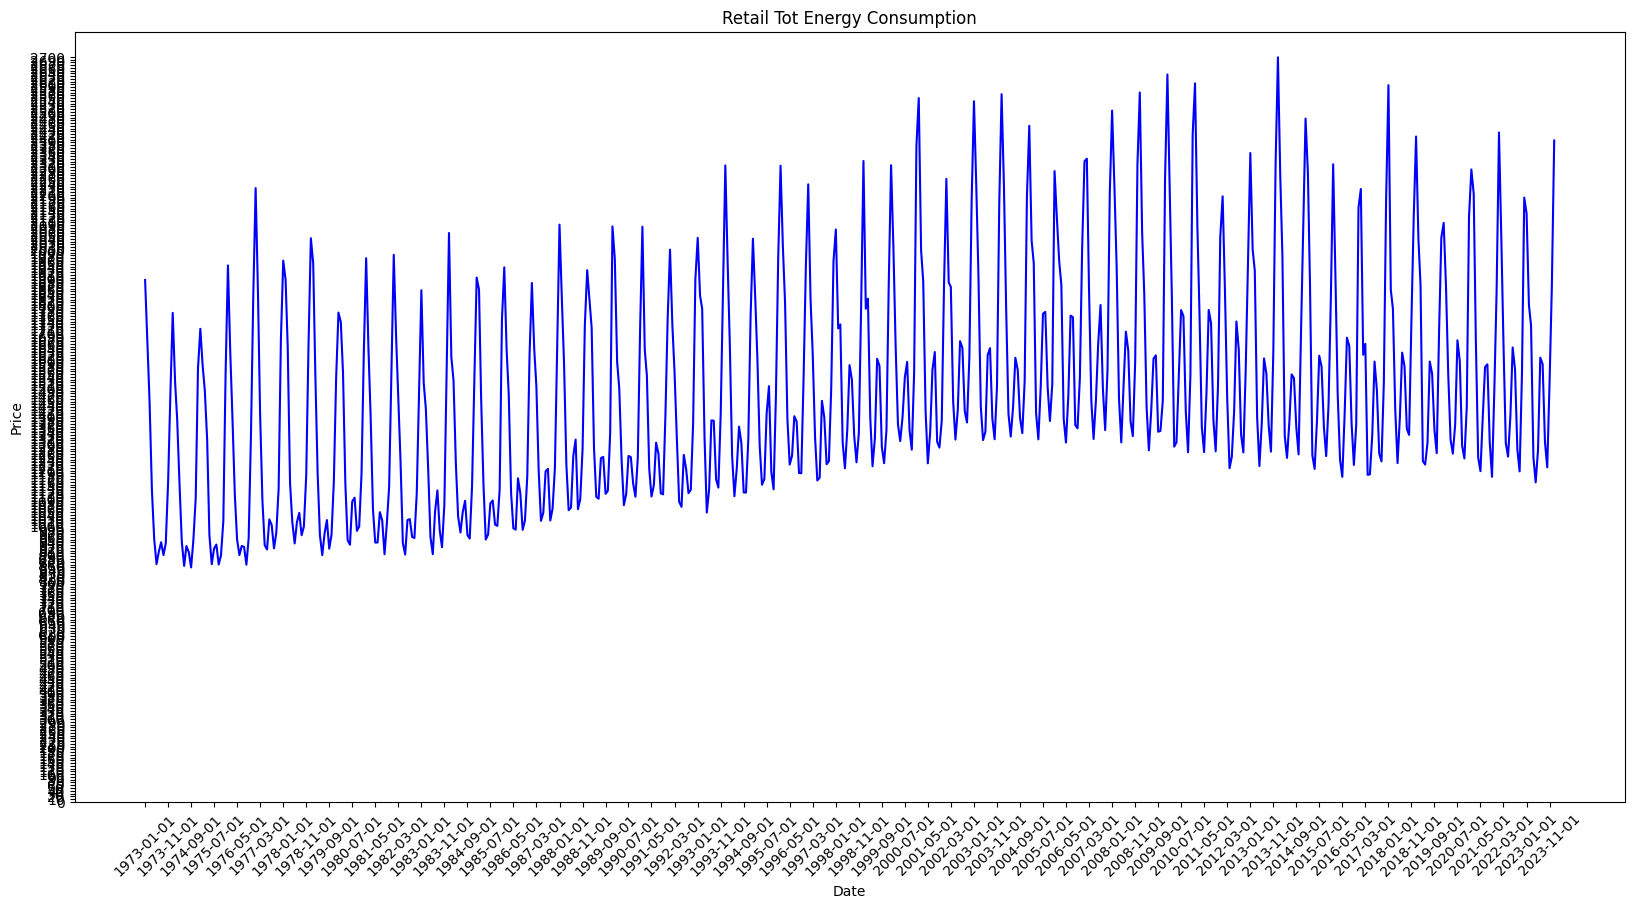

In [71]:
# Convert 'Value' column to float
dataset['Value'] = dataset['Value'].astype(float)

print(dataset['Value'])

plt.figure(figsize=(20, 10))
plt.plot(dataset['Date'], dataset['Value'], color='blue')
plt.title('Retail Tot Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Price')
plt.yticks(range(0, int(max(dataset['Value']))+10, 10))
plt.xticks(dataset['Date'][::10])
plt.xticks(rotation=45)
plt.show()

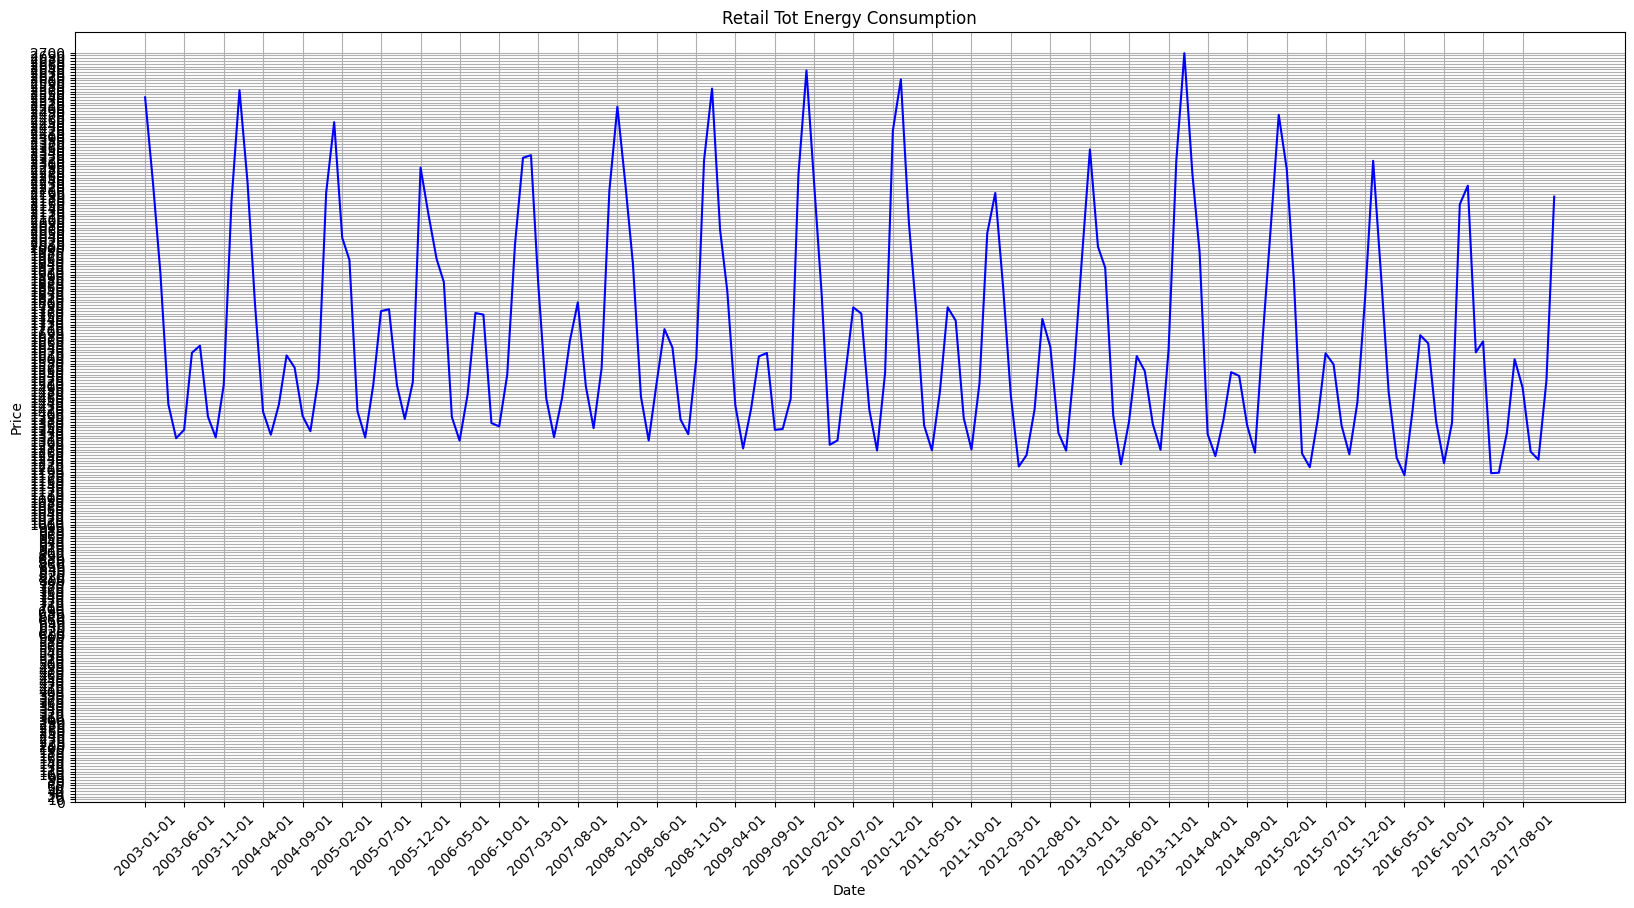

In [72]:
# Filter the data for the last 15 years prior to 2018
last_15_years = dataset[(dataset['Date'] >= '2003-01-01') & (dataset['Date'] < '2018-01-01')]

plt.figure(figsize=(20, 10))
plt.plot(last_15_years['Date'], last_15_years['Value'], color='blue')
plt.title('Retail Tot Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Price')
plt.yticks(range(0, int(max(dataset['Value']))+10, 10))
plt.xticks(last_15_years['Date'][::5])
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Ensure the 'Value' column is numeric

last_15_years.loc[:, 'Value'] = pd.to_numeric(last_15_years['Value'])

# Check stationarity using Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    if result[1] <= 0.05:
        print("Stationary (Reject Null Hypothesis)")
    else:
        print("Non-Stationary (Fail to Reject Null Hypothesis)")

# Check stationarity of the original series
print("Stationarity Test for Original Series:")
check_stationarity(last_15_years['Value'])

Stationarity Test for Original Series:
ADF Statistic: -1.6515272326964343
p-value: 0.4562440496972709
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Non-Stationary (Fail to Reject Null Hypothesis)


In [10]:
# transform the data (e.g., take natural logarithm) because original time series is non-stationary
last_15_years.loc[:, 'Log_Value'] = np.log(last_15_years['Value'])

# Check stationarity of the transformed series
print("Stationarity Test for Log-Transformed Series:")
check_stationarity(last_15_years['Log_Value'])

Stationarity Test for Log-Transformed Series:
ADF Statistic: -1.4106427293851964
p-value: 0.577163358952943
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Non-Stationary (Fail to Reject Null Hypothesis)


C:\Users\tcola\AppData\Local\Temp\ipykernel_104192\2270632550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_15_years.loc[:, 'Log_Value'] = np.log(last_15_years['Value'])


In [11]:
# Create a copy of the DataFrame
last_15_years_copy = last_15_years.copy()

# Take the first difference of the log-transformed series
last_15_years_copy['Diff_Log_Value'] = last_15_years_copy['Log_Value'].diff()

# Remove NaN values resulting from differencing
last_15_years_copy.dropna(inplace=True)

# Re-concatenate the dates back with the 'Diff_Log_Value' column
last_15_years_copy['Date'] = last_15_years['Date']

# Set the 'Date' column as the index
last_15_years_copy.set_index('Date', inplace=True)

# Check the resulting DataFrame
print(last_15_years_copy.head())

# Check stationarity of the differenced series
print("Stationarity Test for First Difference of Log-Transformed Series:")
check_stationarity(last_15_years_copy['Diff_Log_Value'])


                MSN     Value  Column_Order  \
Date                                          
2003-02-01  TERCBUS  2225.165            13   
2003-03-01  TERCBUS  1907.592            13   
2003-04-01  TERCBUS  1432.416            13   
2003-05-01  TERCBUS  1310.895            13   
2003-06-01  TERCBUS  1341.492            13   

                                                Description          Unit  \
Date                                                                        
2003-02-01  Total Energy Consumed by the Residential Sector  Trillion Btu   
2003-03-01  Total Energy Consumed by the Residential Sector  Trillion Btu   
2003-04-01  Total Energy Consumed by the Residential Sector  Trillion Btu   
2003-05-01  Total Energy Consumed by the Residential Sector  Trillion Btu   
2003-06-01  Total Energy Consumed by the Residential Sector  Trillion Btu   

            Log_Value  Diff_Log_Value  
Date                                   
2003-02-01   7.707586       -0.131968  
2003-03-01

In [12]:
final = pd.DataFrame(last_15_years_copy.drop(columns=['MSN', 'Column_Order', 'Description', 'Unit', 'Log_Value', 'Value']))
final.head()

,Diff_Log_Value
Date,
2003-02-01,-0.131968
2003-03-01,-0.153989
2003-04-01,-0.286479
2003-05-01,-0.088652
2003-06-01,0.023072


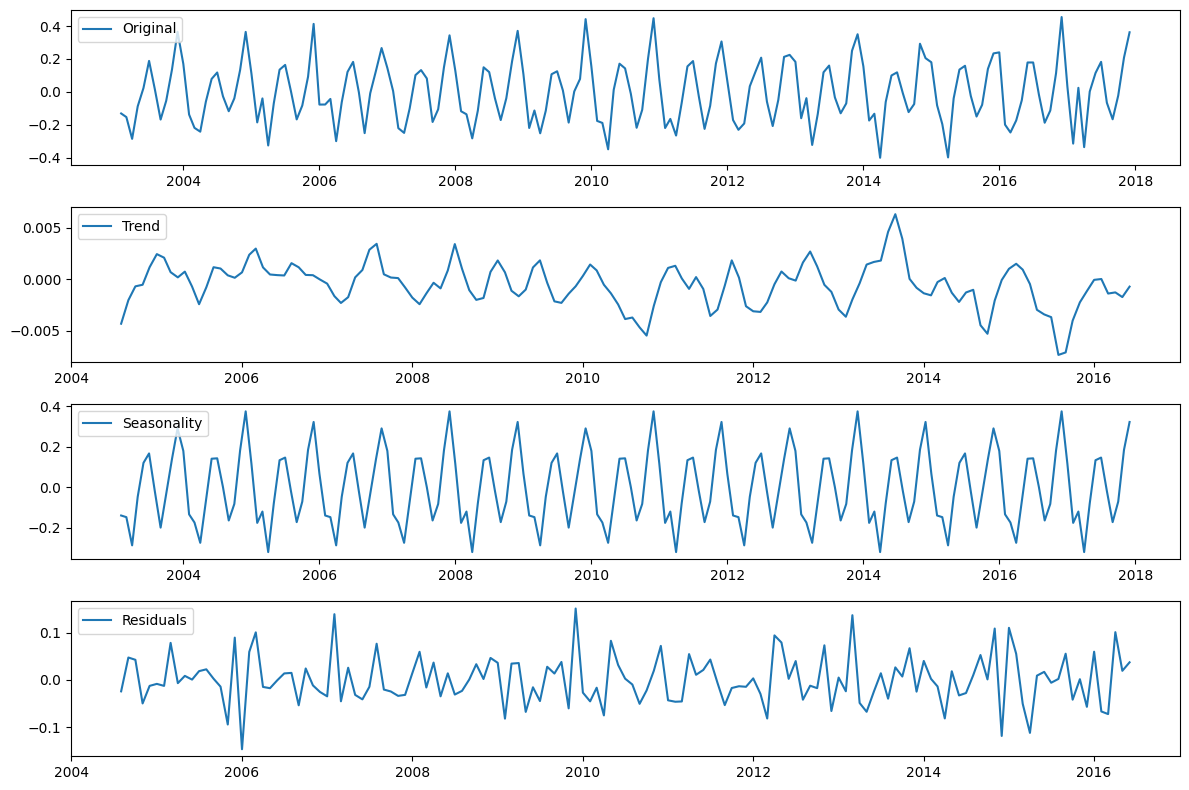

Best period: 36


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

time_series_data = final['Diff_Log_Value']

# Define a list of period values to test
period_values = [i for i in range(4, 48)]  # Testing periods from 1 to 24

# Initialize variables to store the best period and minimum sum of squared residuals
best_period = None
min_ssr = float('inf')

# Iterate over the period values
for period in period_values:
    # Perform decomposition for the current period value
    decomposition = seasonal_decompose(time_series_data, model='additive', period=period)
    
    # Calculate the sum of squared residuals
    ssr = np.sum(decomposition.resid ** 2)
    
    # Check if the current period yields a lower sum of squared residuals
    if ssr < min_ssr:
        min_ssr = ssr
        best_period = period

# Use the best period value for decomposition
decomposition = seasonal_decompose(time_series_data, model='additive', period=best_period)

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(time_series_data, label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Best period:", best_period)


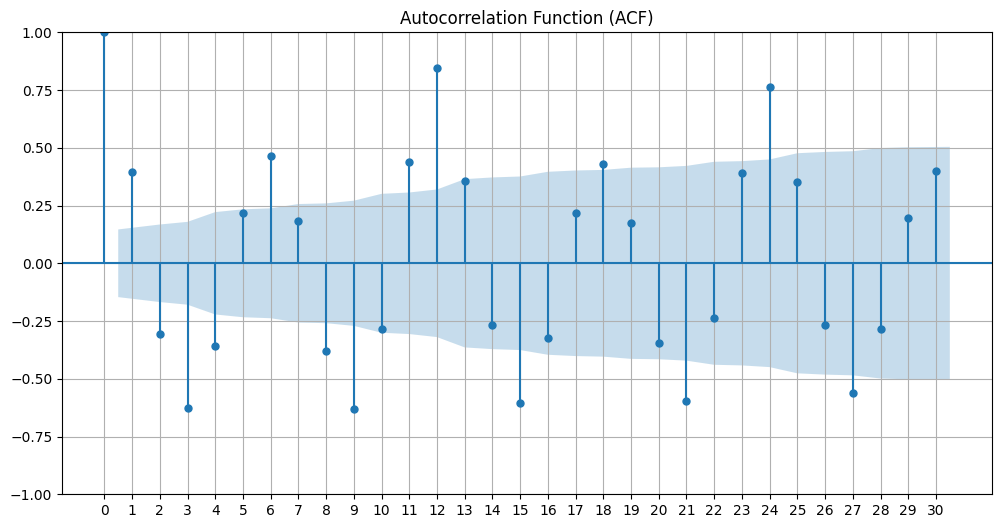

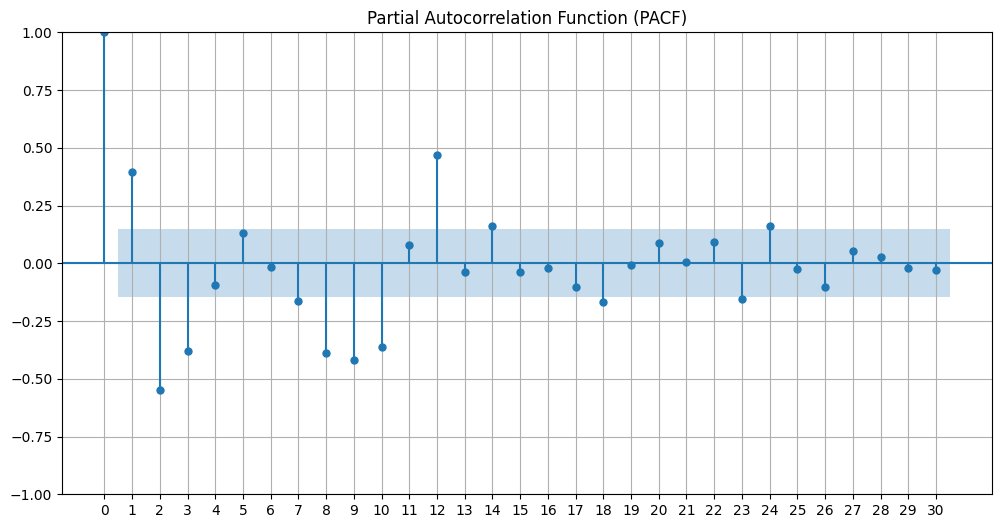

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF
fig_acf = plt.figure(figsize=(12, 6))
ax_acf = fig_acf.add_subplot(111)
plot_acf(final, lags=30, ax=ax_acf)
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)

# Customize x-axis ticks for ACF
ax_acf.set_xticks(range(0, 31, 1))  # Set x-axis ticks every 2 lags
plt.show()

# Plot PACF
fig_pacf = plt.figure(figsize=(12, 6))
ax_pacf = fig_pacf.add_subplot(111)
plot_pacf(final, lags=30, ax=ax_pacf)
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)

# Customize x-axis ticks for PACF
ax_pacf.set_xticks(range(0, 31, 1))  # Set x-axis ticks every 2 lags
plt.show()

C:\Users\tcola\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tcola\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tcola\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error (MSE): 0.011209471450204705
Root Mean Squared Error (RMSE): 0.10587479138210713


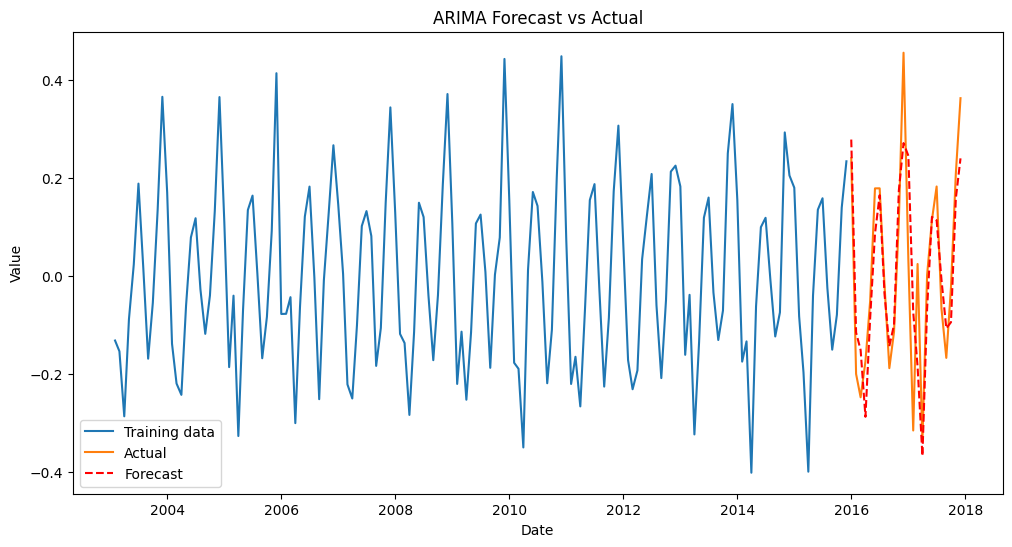

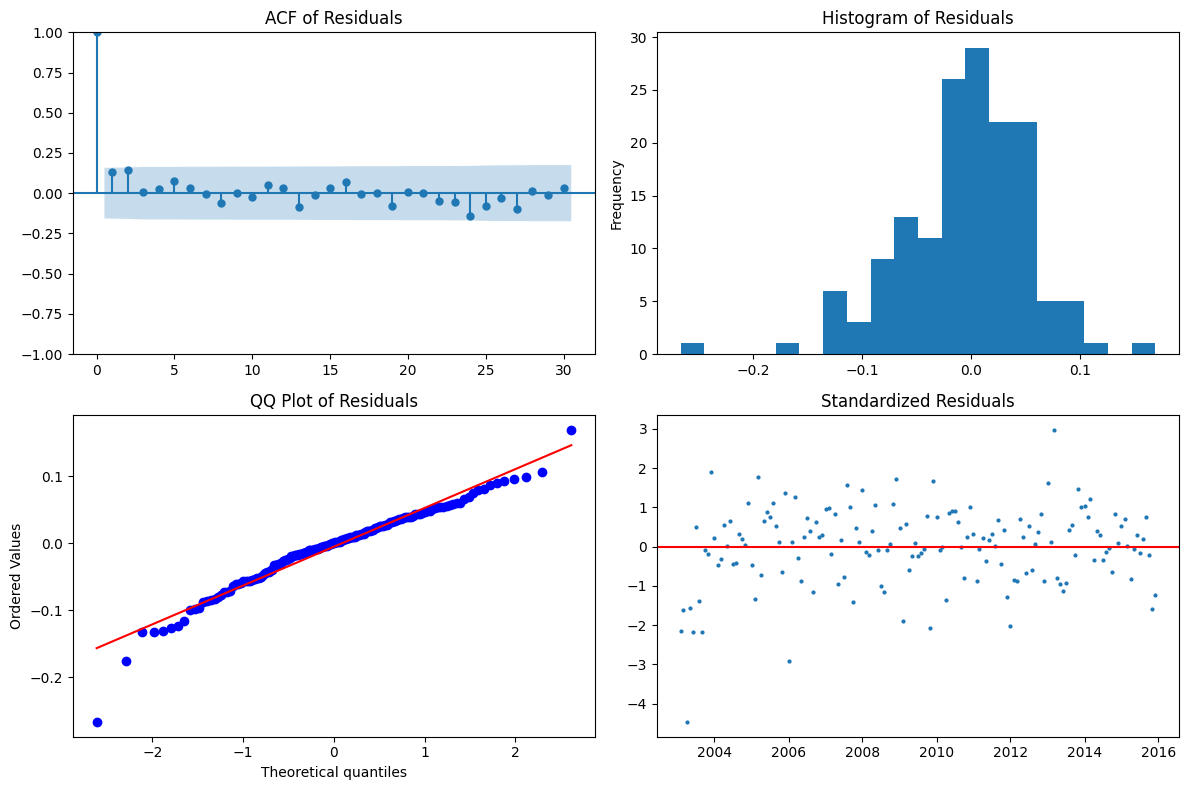

Summary before removing outliers:
                               SARIMAX Results                                
Dep. Variable:         Diff_Log_Value   No. Observations:                  155
Model:               ARIMA(25, 0, 12)   Log Likelihood                 231.565
Date:                Sun, 28 Apr 2024   AIC                           -385.130
Time:                        14:30:19   BIC                           -266.436
Sample:                    02-01-2003   HQIC                          -336.919
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.357      0.721      -0.003       0.002
ar.L1         -0.4775      1.015     -0.471      0.638      -2.466       1.511
ar.L2         -0.1

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# Assuming 'final' is your final dataset
final.index.freq = 'MS'

# Split data into training and testing sets
train = final.iloc[:-24]
test = final.iloc[-24:]

# Fit ARIMA model to training set
p = 25  # Example value for AR order
d = 0  # Example value for differencing order
q = 12  # Example value for MA order
model = ARIMA(train, order=(p, d, q))
arima_result = model.fit()

# Forecast the next 24 months
forecast_horizon = 24
forecast = arima_result.forecast(steps=forecast_horizon)

# Compare forecasted values with actual values
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training data')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast.index, forecast, color='red', linestyle='--', label='Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF of residuals
plot_acf(arima_result.resid, ax=axes[0, 0], lags=30)
axes[0, 0].set_title('ACF of Residuals')

# Plot histogram of residuals
arima_result.resid.plot.hist(ax=axes[0, 1], bins=20)
axes[0, 1].set_title('Histogram of Residuals')

# Plot QQ plot of residuals
stats.probplot(arima_result.resid, dist="norm", plot=axes[1, 0])
axes[1, 0].get_lines()[1].set_color('red')  # Set color of reference line to red for better visibility
axes[1, 0].set_title('QQ Plot of Residuals')

# Plot standardized residuals
residuals_standardized = (arima_result.resid - arima_result.resid.mean()) / arima_result.resid.std()
axes[1, 1].plot(residuals_standardized, linestyle='None', marker='o', markersize=2)
axes[1, 1].axhline(y=0, color='r', linestyle='-')
axes[1, 1].set_title('Standardized Residuals')

plt.tight_layout()
plt.show()

# Print summary of the ARIMA model
print("Summary before removing outliers:")
print(arima_result.summary())

C:\Users\tcola\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tcola\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tcola\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


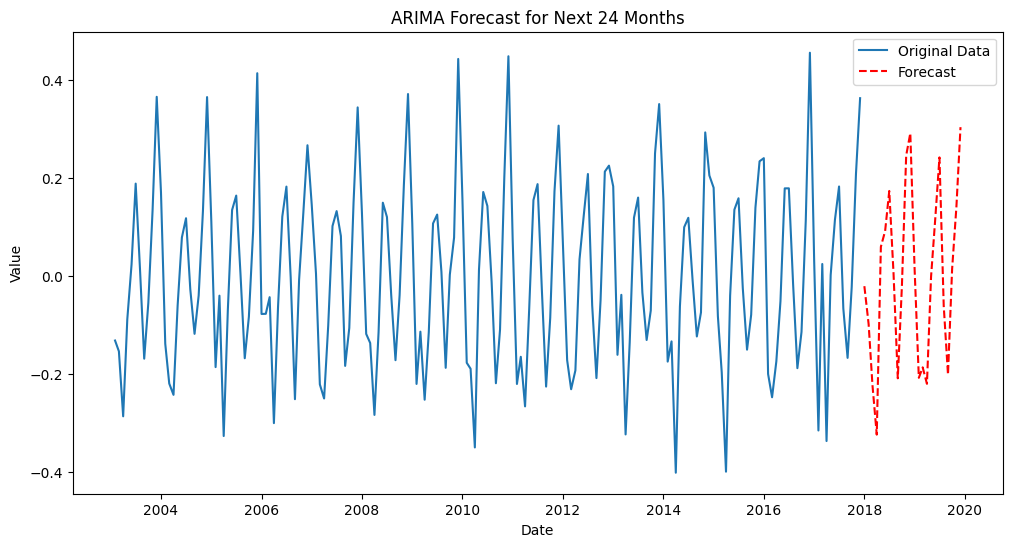

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'final' index is frequency 'MS' (Monthly)
final.index.freq = 'MS'

# Fit ARIMA model to entire dataset
p = 25  # Example value for AR order
d = 0   # Example value for differencing order
q = 12  # Example value for MA order
model = ARIMA(final, order=(p, d, q))
arima_result = model.fit()

# Forecast the next 24 months
forecast_horizon = 24
forecast = arima_result.forecast(steps=forecast_horizon)

# Plot historical data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(final.index, final, label='Original Data')
plt.plot(forecast.index, forecast, color='red', linestyle='--', label='Forecast')
plt.title('ARIMA Forecast for Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


VAR model forecasting

In [62]:
dfcomm = pd.read_csv("CommercialEnergyConsumption.csv")
dftrans = pd.read_csv("TransportationEnergyConsumption.csv")

In [63]:
dfcomm1 = dfcomm[dfcomm['Description'] == 'Total Energy Consumed by the Commercial Sector']
dftrans1 = dftrans[dftrans['Description'] == 'Total Energy Consumed by the Transportation Sector']
print(tabulate(dfcomm1.head(), headers='keys', tablefmt='psql', showindex=False))

+---------+----------+---------+----------------+------------------------------------------------+--------------+
| MSN     |   YYYYMM |   Value |   Column_Order | Description                                    | Unit         |
|---------+----------+---------+----------------+------------------------------------------------+--------------|
| TECCBUS |   194913 | 3428.53 |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   195013 | 3662.76 |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   195113 | 3644.79 |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   195213 | 3638.29 |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   195313 | 3552    |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
+---------+----------+---------+----------------+---------------------------------------

In [64]:
# Copy the DataFrame to avoid modifying a slice
dfcomm2 = dfcomm1.copy()

dfcomm2.drop(dfcomm2.loc[dfcomm2['YYYYMM'].astype(str).str[-2:] == '13'].index, inplace=True)

print(tabulate(dfcomm2.head(), headers='keys', tablefmt='psql', showindex=False))

+---------+----------+----------+----------------+------------------------------------------------+--------------+
| MSN     |   YYYYMM |    Value |   Column_Order | Description                                    | Unit         |
|---------+----------+----------+----------------+------------------------------------------------+--------------|
| TECCBUS |   197301 | 1035.19  |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   197302 |  963.27  |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   197303 |  841.08  |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   197304 |  693.905 |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
| TECCBUS |   197305 |  649.989 |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu |
+---------+----------+----------+----------------+------------------------------

In [65]:
# Copy the DataFrame to avoid modifying a slice
dftrans2 = dftrans1.copy()

dftrans2.drop(dftrans2.loc[dftrans2['YYYYMM'].astype(str).str[-2:] == '13'].index, inplace=True)

print(tabulate(dftrans2.head(), headers='keys', tablefmt='psql', showindex=False))

+---------+----------+---------+----------------+----------------------------------------------------+--------------+
| MSN     |   YYYYMM |   Value |   Column_Order | Description                                        | Unit         |
|---------+----------+---------+----------------+----------------------------------------------------+--------------|
| TEACBUS |   197301 | 1507.63 |             10 | Total Energy Consumed by the Transportation Sector | Trillion Btu |
| TEACBUS |   197302 | 1440.77 |             10 | Total Energy Consumed by the Transportation Sector | Trillion Btu |
| TEACBUS |   197303 | 1563.82 |             10 | Total Energy Consumed by the Transportation Sector | Trillion Btu |
| TEACBUS |   197304 | 1482.76 |             10 | Total Energy Consumed by the Transportation Sector | Trillion Btu |
| TEACBUS |   197305 | 1624.64 |             10 | Total Energy Consumed by the Transportation Sector | Trillion Btu |
+---------+----------+---------+----------------+-------

In [68]:
# Function to transform the YYYYMM format
def transform_date(date):
    date_str = str(date)
    year = date_str[:4]
    month = date_str[4:]
    return f"{year}-{month}-01"

# Apply the transformation to the column
dfcomm2['Transformed'] = dfcomm2['YYYYMM'].apply(transform_date)
dftrans2['Transformed'] = dftrans2['YYYYMM'].apply(transform_date)

# Convert 'YYYYMM' column to datetime format without specifying the format explicitly
dfcomm2['Date'] = pd.to_datetime(dfcomm2['Transformed'])
dftrans2['Date'] = pd.to_datetime(dftrans2['Transformed'])

dfcomm3 = dfcomm2.drop(columns=['YYYYMM', 'Transformed'])
dftrans3 = dftrans2.drop(columns=['YYYYMM', 'Transformed'])


print("First 5 rows of the modified Commerce DataFrame:")
print(tabulate(dfcomm3.head(), headers='keys', tablefmt='psql', showindex=False))

print("First 5 rows of the modified Transport DataFrame:")
print(tabulate(dftrans3.head(), headers='keys', tablefmt='psql', showindex=False))

First 5 rows of the modified Commerce DataFrame:
+---------+----------+----------------+------------------------------------------------+--------------+---------------------+
| MSN     |    Value |   Column_Order | Description                                    | Unit         | Date                |
|---------+----------+----------------+------------------------------------------------+--------------+---------------------|
| TECCBUS | 1035.19  |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu | 1973-01-01 00:00:00 |
| TECCBUS |  963.27  |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu | 1973-02-01 00:00:00 |
| TECCBUS |  841.08  |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu | 1973-03-01 00:00:00 |
| TECCBUS |  693.905 |             15 | Total Energy Consumed by the Commercial Sector | Trillion Btu | 1973-04-01 00:00:00 |
| TECCBUS |  649.989 |             15 | Total Energy Consumed by the 

9656     1035.189
9657      963.270
9658      841.080
9659      693.905
9660      649.989
           ...   
10314    1239.499
10315    1274.026
10316    1362.436
10317    1472.606
10319    1683.271
Name: Value, Length: 613, dtype: float64
6216    1507.635
6217    1440.768
6218    1563.818
6219    1482.758
6220    1624.645
          ...   
6874    2293.665
6875    2416.708
6876    2292.245
6877    2349.082
6879    2220.546
Name: Value, Length: 613, dtype: float64


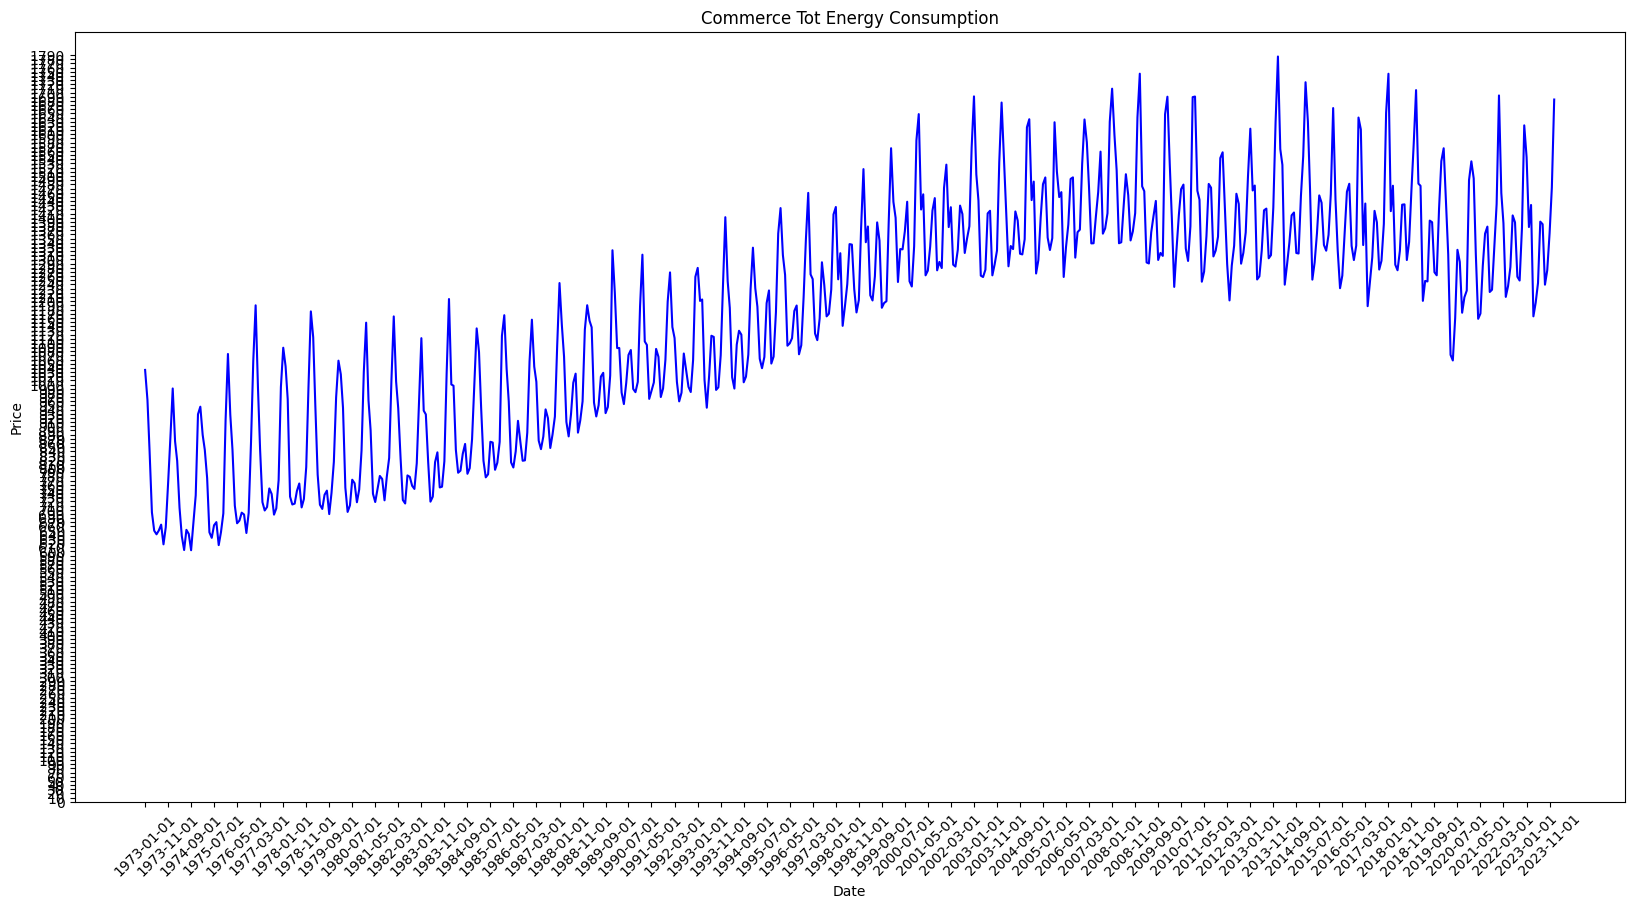

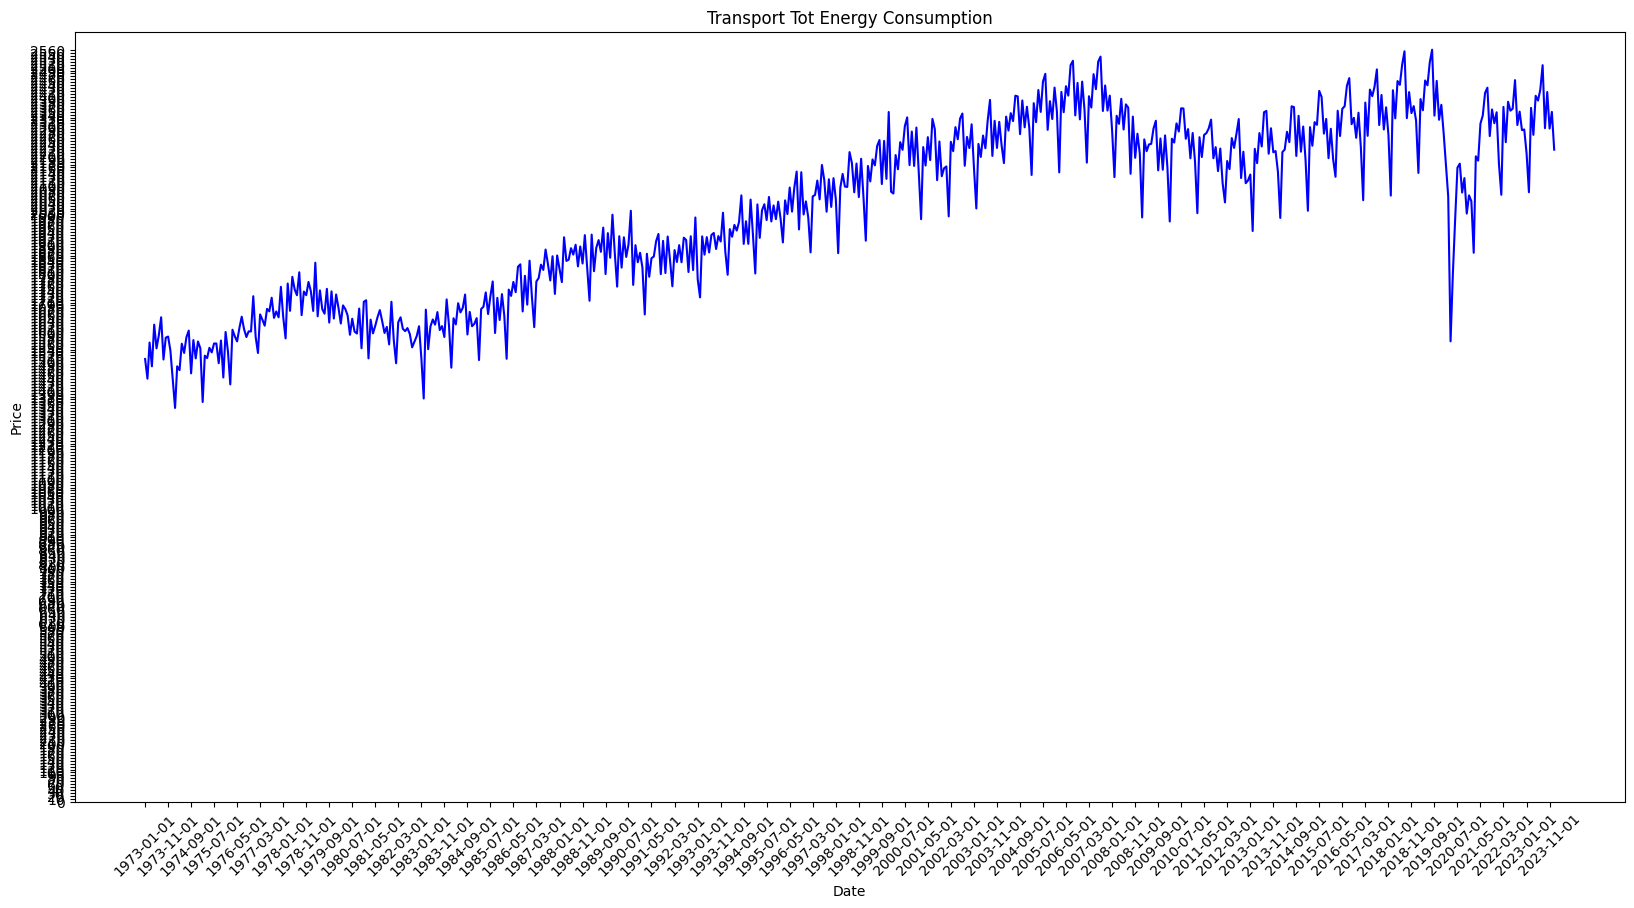

In [73]:
# Convert 'Value' column to float
dfcomm3['Value'] = dfcomm3['Value'].astype(float)
dftrans3['Value'] = dftrans3['Value'].astype(float)

print(dfcomm3['Value'])
print(dftrans3['Value'])

plt.figure(figsize=(20, 10))
plt.plot(dfcomm3['Date'], dfcomm3['Value'], color='blue')
plt.title('Commerce Tot Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Price')
plt.yticks(range(0, int(max(dfcomm3['Value']))+10, 10))
plt.xticks(dfcomm3['Date'][::10])
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(dftrans3['Date'], dftrans3['Value'], color='blue')
plt.title('Transport Tot Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Price')
plt.yticks(range(0, int(max(dftrans3['Value']))+10, 10))
plt.xticks(dftrans3['Date'][::10])
plt.xticks(rotation=45)
plt.show()

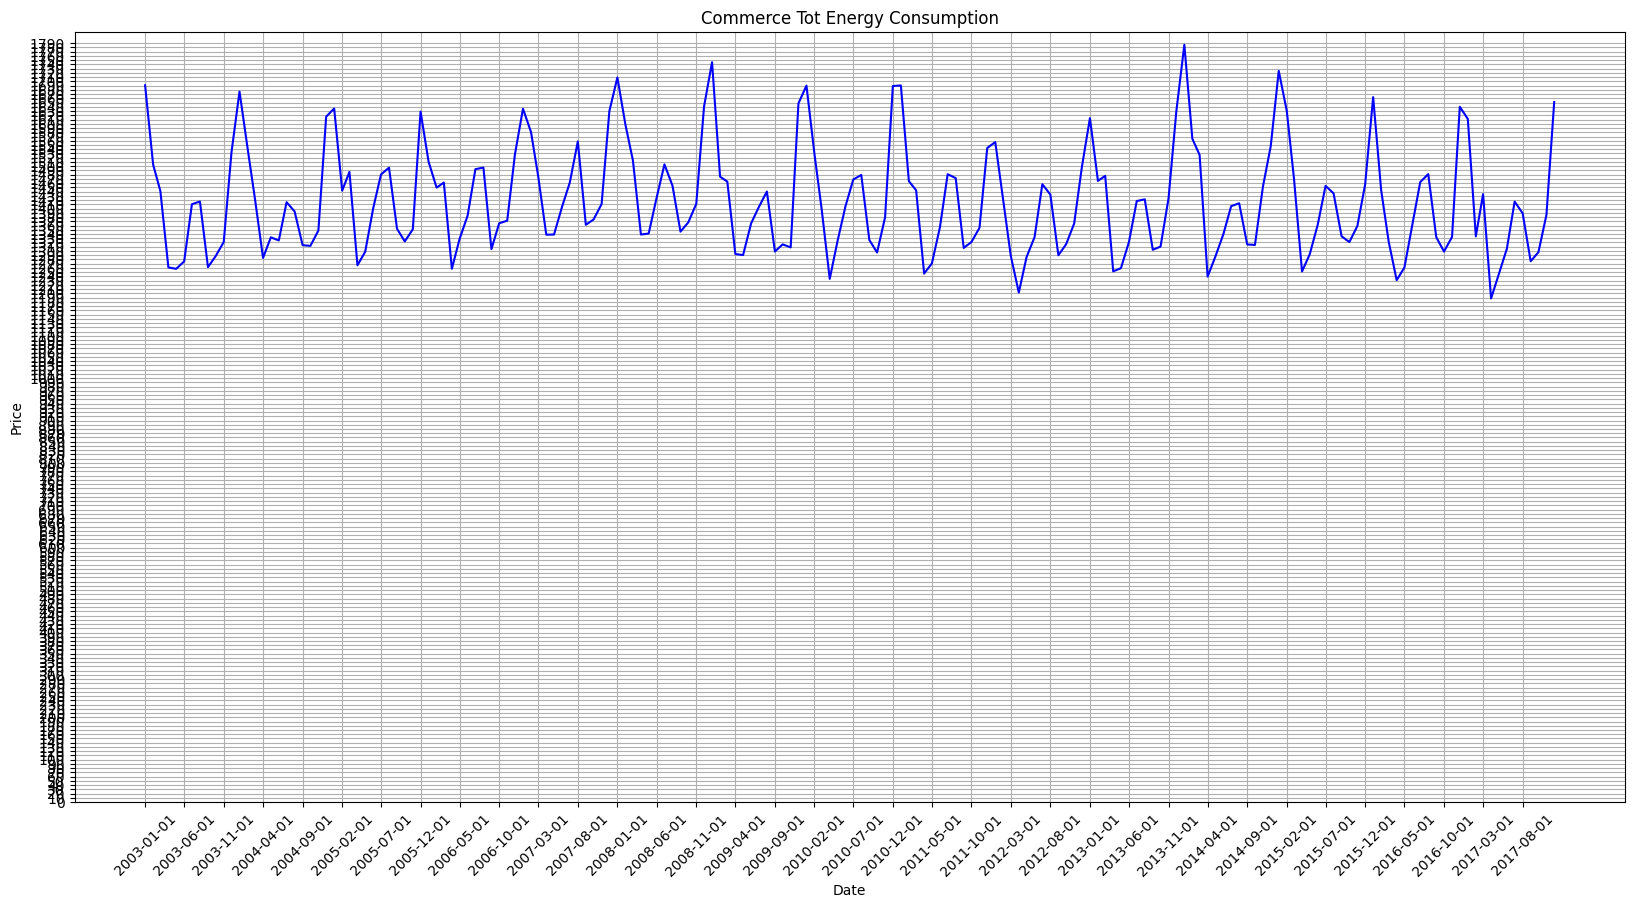

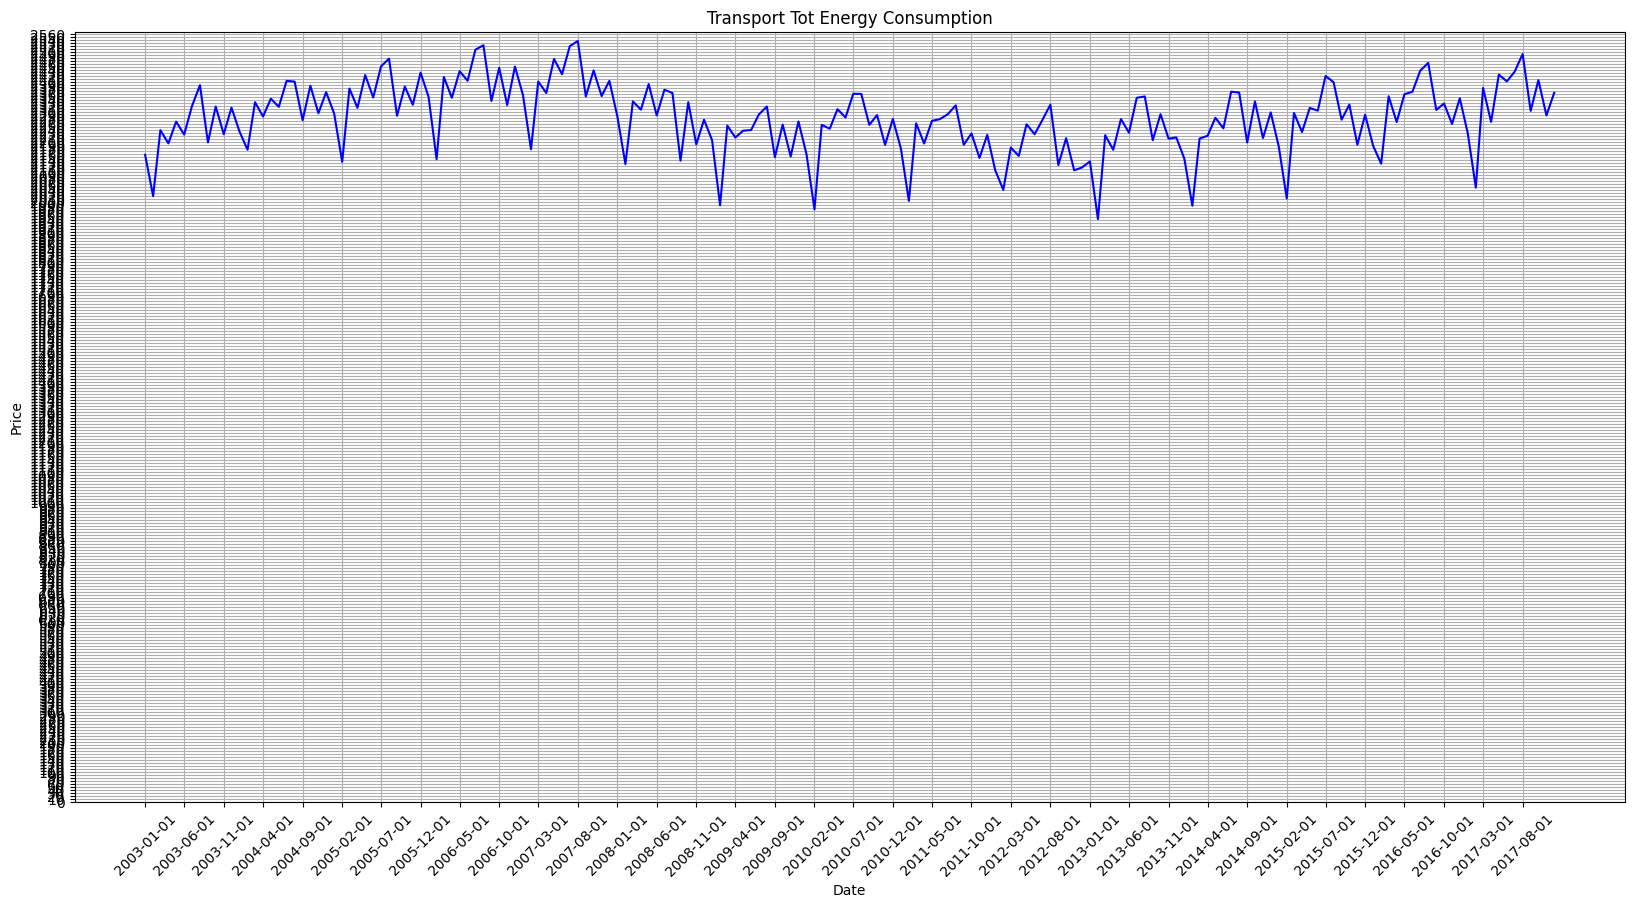

In [76]:
# Filter the data for the last 15 years prior to 2018
dfcomm_last_15_years = dfcomm3[(dfcomm3['Date'] >= '2003-01-01') & (dfcomm3['Date'] < '2018-01-01')]

plt.figure(figsize=(20, 10))
plt.plot(dfcomm_last_15_years['Date'], dfcomm_last_15_years['Value'], color='blue')
plt.title('Commerce Tot Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Price')
plt.yticks(range(0, int(max(dfcomm3['Value']))+10, 10))
plt.xticks(dfcomm_last_15_years['Date'][::5])
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Filter the data for the last 15 years prior to 2018
dftrans_last_15_years = dftrans3[(dftrans3['Date'] >= '2003-01-01') & (dftrans3['Date'] < '2018-01-01')]

plt.figure(figsize=(20, 10))
plt.plot(dftrans_last_15_years['Date'], dftrans_last_15_years['Value'], color='blue')
plt.title('Transport Tot Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Price')
plt.yticks(range(0, int(max(dftrans3['Value']))+10, 10))
plt.xticks(dftrans_last_15_years['Date'][::5])
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [104]:
# transform the data (e.g., take natural logarithm) because original time series is non-stationary
dfcomm_last_15_years.loc[:, 'Log_Value'] = np.log(dfcomm_last_15_years['Value'])
dftrans_last_15_years.loc[:, 'Log_Value'] = np.log(dftrans_last_15_years['Value'])

# Check stationarity of the transformed series
print("Commerce Stationarity Test for Log-Transformed Series:")
check_stationarity(dfcomm_last_15_years['Log_Value'])
print()
print("Transport Stationarity Test for Log-Transformed Series:")
check_stationarity(dftrans_last_15_years['Log_Value'])

Commerce Stationarity Test for Log-Transformed Series:
ADF Statistic: -2.2838780222563853
p-value: 0.1772203605458068
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Non-Stationary (Fail to Reject Null Hypothesis)

Transport Stationarity Test for Log-Transformed Series:
ADF Statistic: -1.9587915536583185
p-value: 0.30492855794514784
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Non-Stationary (Fail to Reject Null Hypothesis)


In [105]:
print("Transport Head")
print(dftrans_last_15_years.head())

Transport Head
          MSN     Value  Column_Order  \
6606  TEACBUS  2157.923            10   
6607  TEACBUS  2020.249            10   
6608  TEACBUS  2239.958            10   
6609  TEACBUS  2195.852            10   
6610  TEACBUS  2268.530            10   

                                            Description          Unit  \
6606  Total Energy Consumed by the Transportation Se...  Trillion Btu   
6607  Total Energy Consumed by the Transportation Se...  Trillion Btu   
6608  Total Energy Consumed by the Transportation Se...  Trillion Btu   
6609  Total Energy Consumed by the Transportation Se...  Trillion Btu   
6610  Total Energy Consumed by the Transportation Se...  Trillion Btu   

           Date  Log_Value  
6606 2003-01-01   7.676901  
6607 2003-02-01   7.610976  
6608 2003-03-01   7.714212  
6609 2003-04-01   7.694325  
6610 2003-05-01   7.726887  


In [106]:
# Create a copy of the DataFrame
dfcomm1_last_15_years = dfcomm_last_15_years.copy()
dftrans1_last_15_years = dftrans_last_15_years.copy()


# Take the first difference of the log-transformed series
dfcomm1_last_15_years['Diff_Log_Value'] = dfcomm1_last_15_years['Log_Value'].diff()
dftrans1_last_15_years['Diff_Log_Value'] = dftrans1_last_15_years['Log_Value'].diff()

# Remove NaN values resulting from differencing
dfcomm1_last_15_years.dropna(inplace=True)
dftrans1_last_15_years.dropna(inplace=True)

# Re-concatenate the dates back with the 'Diff_Log_Value' column
dfcomm1_last_15_years['Date'] = dfcomm_last_15_years['Date']
dftrans1_last_15_years['Date'] = dftrans_last_15_years['Date']

# Set the 'Date' column as the index
dfcomm1_last_15_years.set_index('Date', inplace=True)
dftrans1_last_15_years.set_index('Date', inplace=True)

# Check stationarity of the differenced series
print("Commerce Stationarity Test for First Difference of Log-Transformed Series:")
check_stationarity(dfcomm1_last_15_years['Diff_Log_Value'])
print()
print("Transport Stationarity Test for First Difference of Log-Transformed Series:")
check_stationarity(dftrans1_last_15_years['Diff_Log_Value'])

# Check the resulting DataFrame
print("Commerce Head")
print(tabulate(dfcomm1_last_15_years.head()))
print()
print("Transport Head")
print(tabulate(dftrans1_last_15_years.head()))


Commerce Stationarity Test for First Difference of Log-Transformed Series:
ADF Statistic: -4.511063562661156
p-value: 0.0001877839103181262
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Stationary (Reject Null Hypothesis)

Transport Stationarity Test for First Difference of Log-Transformed Series:
ADF Statistic: -2.7733901906416296
p-value: 0.06217647013048056
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Non-Stationary (Fail to Reject Null Hypothesis)
Commerce Head
-------------------  -------  -------  --  ----------------------------------------------  ------------  -------  -----------
2003-02-01 00:00:00  TECCBUS  1503.78  15  Total Energy Consumed by the Commercial Sector  Trillion Btu  7.31574  -0.117235
2003-03-01 00:00:00  TECCBUS  1441.42  15  Total Energy Consumed by the Commercial Sector  Trillion Btu  7.27338  -0.0423505
2003-04-01 00:00:00  TECCBUS  1261.23  15  Total Energy Consumed b

Transportation dataset isnt stationary after log difference. Let's try box cox

In [109]:
from scipy.stats import boxcox

# Apply Box-Cox transformation to the transportation dataset
transformed_values, lambda_value = boxcox(dftrans1_last_15_years['Diff_Log_Value'] + 1)  # Adding 1 to handle zero values

# Update the 'Diff_Log_Value' column with the transformed values
dftrans1_last_15_years['Diff_Log_Value'] = transformed_values

# Check stationarity of the transformed series
print("Transport Stationarity Test after Box-Cox Transformation:")
check_stationarity(dftrans1_last_15_years['Diff_Log_Value'])

print("Transport Head")
dftrans1_last_15_years.head()

Transport Stationarity Test after Box-Cox Transformation:
ADF Statistic: -2.907505283564222
p-value: 0.04448217032853226
Critical Values:
	1%: -3.4703698981001665
	5%: -2.8791138497902193
	10%: -2.576139407751488
Stationary (Reject Null Hypothesis)
Transport Head


,MSN,Value,Column_Order,Description,Unit,Log_Value,Diff_Log_Value
Date,,,,,,,
2003-02-01,TEACBUS,2020.249,10,Total Energy Consumed by the Transportation Se...,Trillion Btu,7.610976,-0.072945
2003-03-01,TEACBUS,2239.958,10,Total Energy Consumed by the Transportation Se...,Trillion Btu,7.714212,0.089531
2003-04-01,TEACBUS,2195.852,10,Total Energy Consumed by the Transportation Se...,Trillion Btu,7.694325,-0.020484
2003-05-01,TEACBUS,2268.530,10,Total Energy Consumed by the Transportation Se...,Trillion Btu,7.726887,0.031071
2003-06-01,TEACBUS,2225.247,10,Total Energy Consumed by the Transportation Se...,Trillion Btu,7.707623,-0.019824


Problem: we now need to apply box cox to the other 2 datasets to ensure consistency. Let's do that.

In [110]:
# Apply Box-Cox transformation to the transportation dataset
transformed_values, lambda_value = boxcox(dfcomm1_last_15_years['Diff_Log_Value'] + 1)  # Adding 1 to handle zero values

# Update the 'Diff_Log_Value' column with the transformed values
dfcomm1_last_15_years['Diff_Log_Value'] = transformed_values

# Check stationarity of the transformed series
print("Transport Stationarity Test after Box-Cox Transformation:")
check_stationarity(dfcomm1_last_15_years['Diff_Log_Value'])

print("Commerce Head")
dfcomm1_last_15_years.head()

Transport Stationarity Test after Box-Cox Transformation:
ADF Statistic: -4.542637035916902
p-value: 0.00016455003825358844
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Stationary (Reject Null Hypothesis)
Transport Head


,MSN,Value,Column_Order,Description,Unit,Log_Value,Diff_Log_Value
Date,,,,,,,
2003-02-01,TECCBUS,1503.777,15,Total Energy Consumed by the Commercial Sector,Trillion Btu,7.315735,-0.114391
2003-03-01,TECCBUS,1441.421,15,Total Energy Consumed by the Commercial Sector,Trillion Btu,7.273385,-0.041985
2003-04-01,TECCBUS,1261.226,15,Total Energy Consumed by the Commercial Sector,Trillion Btu,7.139840,-0.129842
2003-05-01,TECCBUS,1257.814,15,Total Energy Consumed by the Commercial Sector,Trillion Btu,7.137131,-0.002707
2003-06-01,TECCBUS,1275.340,15,Total Energy Consumed by the Commercial Sector,Trillion Btu,7.150968,0.013876


In [111]:
dfretail1_last_15_years = final

# Apply Box-Cox transformation to the transportation dataset
transformed_values, lambda_value = boxcox(dfretail1_last_15_years['Diff_Log_Value'] + 1)  # Adding 1 to handle zero values

# Update the 'Diff_Log_Value' column with the transformed values
dfretail1_last_15_years['Diff_Log_Value'] = transformed_values

# Check stationarity of the transformed series
print("Transport Stationarity Test after Box-Cox Transformation:")
check_stationarity(dfretail1_last_15_years['Diff_Log_Value'])

print("Commerce Head")
dfretail1_last_15_years.head()

Transport Stationarity Test after Box-Cox Transformation:
ADF Statistic: -4.57606695388513
p-value: 0.00014294543547537612
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Stationary (Reject Null Hypothesis)
Commerce Head


,Diff_Log_Value
Date,
2003-02-01,-0.137241
2003-03-01,-0.161261
2003-04-01,-0.313836
2003-05-01,-0.090974
2003-06-01,0.022924


In [162]:
commfinal = pd.DataFrame(dfcomm1_last_15_years.drop(columns=['MSN', 'Column_Order', 'Description', 'Unit', 'Log_Value', 'Value']))
commfinal.rename(columns={'Diff_Log_Value': 'commerce_value'}, inplace=True)
commfinal.head()

,commerce_value
Date,
2003-02-01,-0.114391
2003-03-01,-0.041985
2003-04-01,-0.129842
2003-05-01,-0.002707
2003-06-01,0.013876


In [161]:
transfinal = pd.DataFrame(dftrans1_last_15_years.drop(columns=['MSN', 'Column_Order', 'Description', 'Unit', 'Log_Value', 'Value']))
transfinal.rename(columns={'Diff_Log_Value': 'transport_value'}, inplace=True)
transfinal.head()

,transport_value
Date,
2003-02-01,-0.072945
2003-03-01,0.089531
2003-04-01,-0.020484
2003-05-01,0.031071
2003-06-01,-0.019824


In [160]:
retailfinal = pd.DataFrame(dfretail1_last_15_years)
retailfinal.rename(columns={'Diff_Log_Value': 'retail_value'}, inplace=True)
retailfinal.head()

,retail_value
Date,
2003-02-01,-0.137241
2003-03-01,-0.161261
2003-04-01,-0.313836
2003-05-01,-0.090974
2003-06-01,0.022924


VAR model

In [163]:
data = pd.concat([commfinal, transfinal, retailfinal], axis=1)
data.index.freq = 'MS'

data.head()

,commerce_value,transport_value,retail_value
Date,,,
2003-02-01,-0.114391,-0.072945,-0.137241
2003-03-01,-0.041985,0.089531,-0.161261
2003-04-01,-0.129842,-0.020484,-0.313836
2003-05-01,-0.002707,0.031071,-0.090974
2003-06-01,0.013876,-0.019824,0.022924


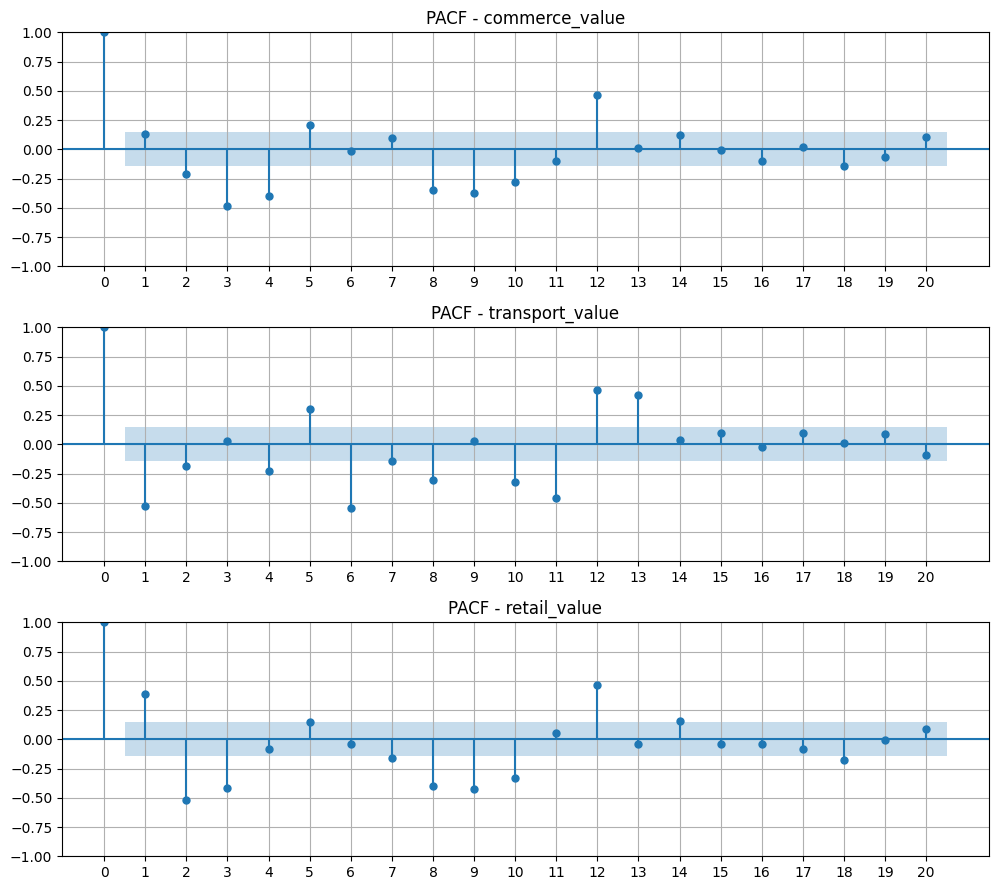

In [170]:
# Plot PACF for each variable in the DataFrame
fig, axs = plt.subplots(nrows=len(data.columns), figsize=(10, 3 * len(data.columns)))

for i, col in enumerate(data.columns):
    ax = axs[i]
    plot_pacf(data[col].values.flatten(), lags=20, ax=ax, title=f'PACF - {col}')
    ax.grid(True)  # Turn on grid
    ax.tick_params(axis='x')  # Rotate x-ticks for better readability
    
    # Customize x-ticks after plotting
    ax.set_xticks(range(21))  # Show x-ticks for lag 0 to lag 20

plt.tight_layout()
plt.show()

In [181]:
from statsmodels.tsa.api import VAR
from tqdm import tqdm
# Define a range of lag orders to test
max_lag = 20  # Maximum lag order to test
results = []  # Store results of model fitting and evaluation

# Iterate over each lag order and fit VAR models
for lag_order in tqdm(range(1, max_lag + 1)):
    # Fit VAR model with the current lag order
    model = VAR(data)
    result = model.fit(lag_order)
    
    # Evaluate model fit using information criteria
    aic = result.aic
    bic = result.bic
    
    # Store results
    results.append({'lag_order': lag_order, 'aic': aic, 'bic': bic})

# Find lag order with the lowest AIC or BIC
best_model = min(results, key=lambda x: x['aic'])  # Change 'aic' to 'bic' if using BIC
best_lag_order = best_model['lag_order']

print(f"Best lag order: {best_lag_order}")

100%|██████████| 20/20 [00:00<00:00, 506.26it/s]

Best lag order: 13


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 28, Apr, 2024
Time:                     15:47:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -19.8648
Nobs:                     166.000    HQIC:                  -21.2013
Log likelihood:           1248.87    FPE:                2.56106e-10
AIC:                     -22.1144    Det(Omega_mle):     1.34012e-10
--------------------------------------------------------------------
Results for equation commerce_value
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.038352         0.015802            2.427           0.015
L1.commerce_value          -0.635431         0.222768           -2.852           0.004
L1.transport_value         

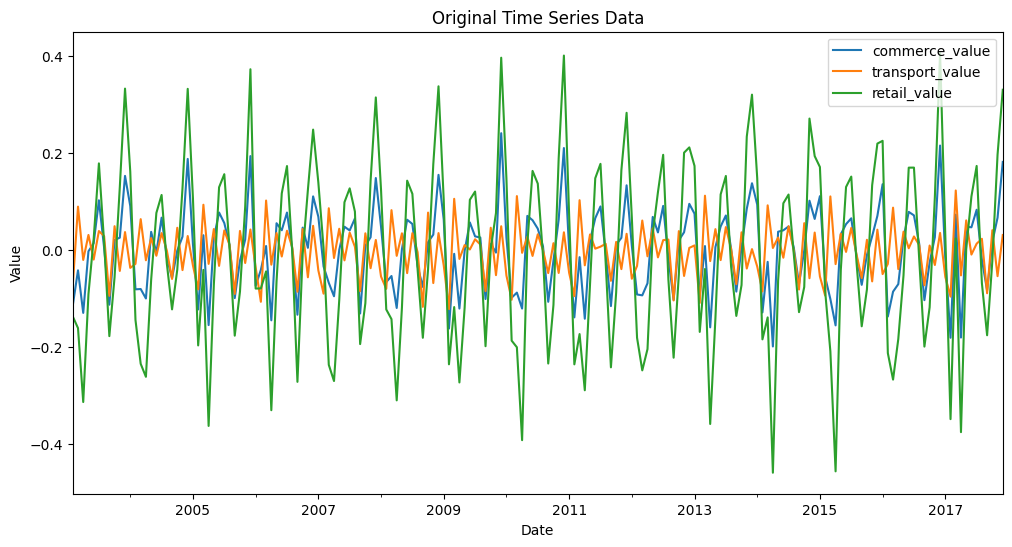

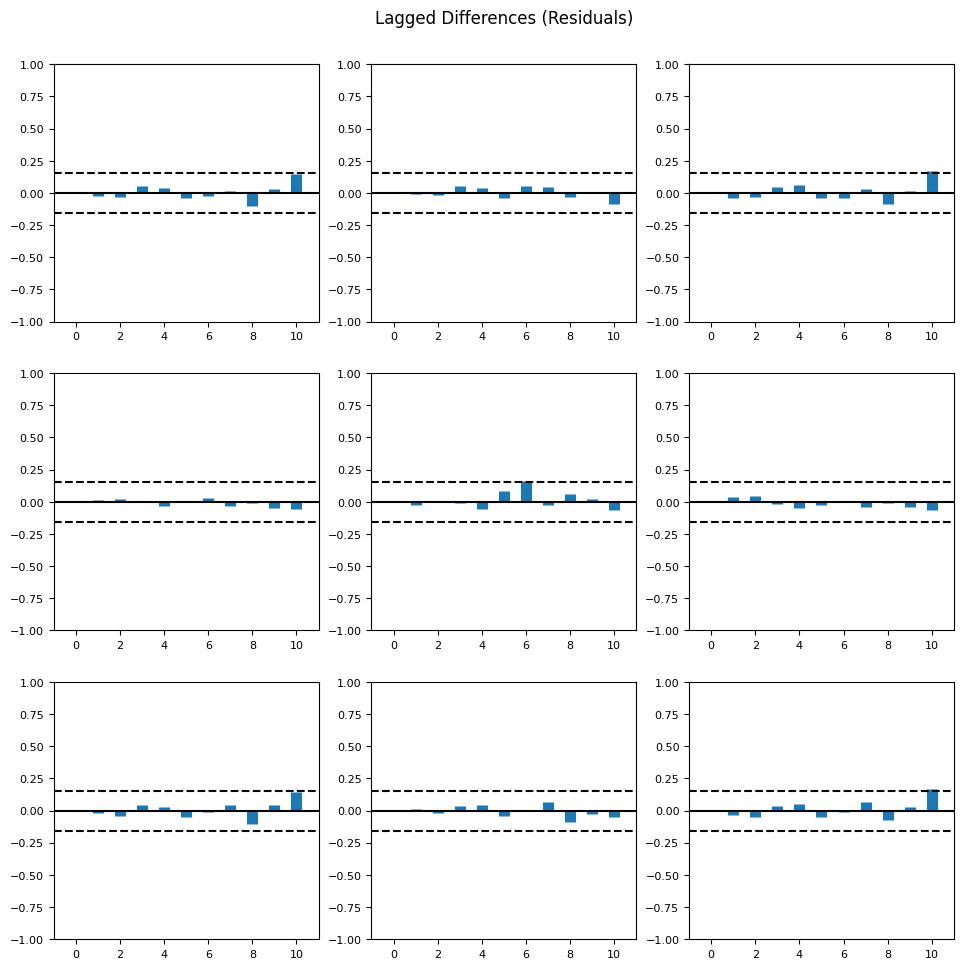

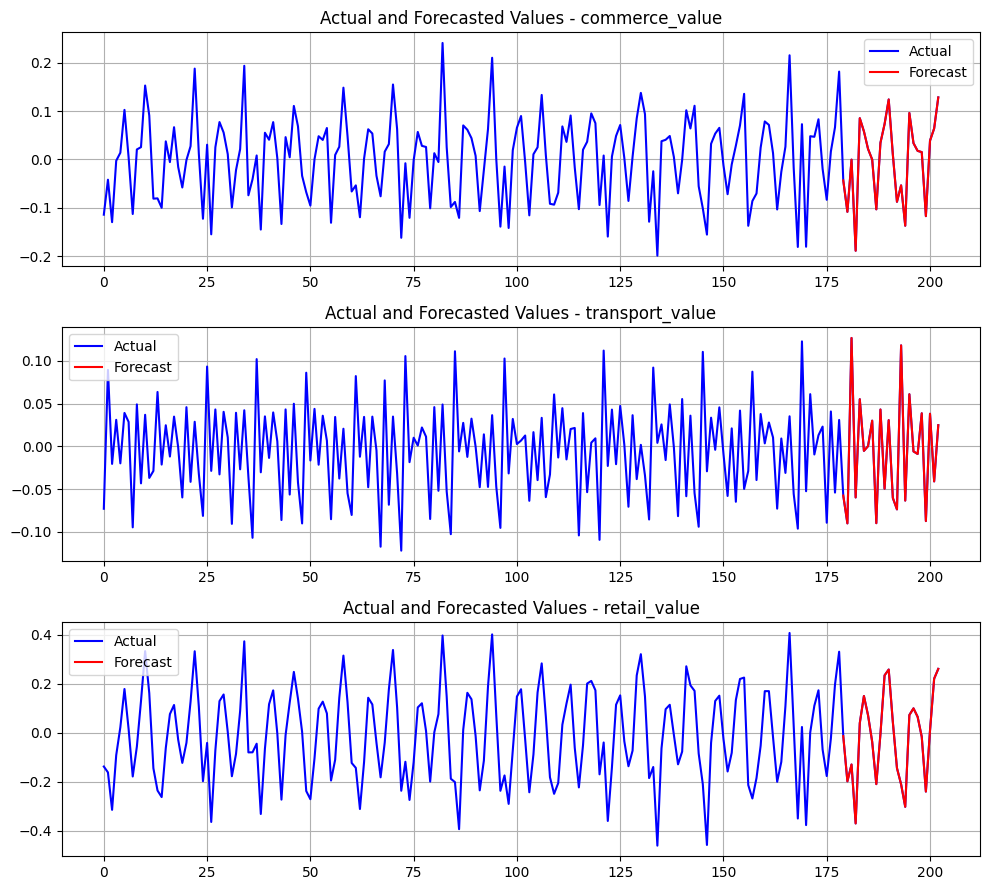

In [182]:
from statsmodels.tsa.api import VAR
# Combine the data into a single DataFrame

# Create and fit VAR model
model = VAR(data)
result = model.fit(best_lag_order)

# Forecast for the next n steps
n_steps = 24
forecast = result.forecast(data.values[-result.k_ar:], steps=n_steps)

# Print model diagnostics
print(result.summary())

# Plot original time series data
data.plot(figsize=(12, 6))
plt.title('Original Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot lagged differences
result.plot_acorr()
plt.suptitle('Lagged Differences (Residuals)')
plt.show()

# Combine actual and forecasted values
actual_and_forecast = np.concatenate([data.values, forecast], axis=0)

# Plot actual and forecasted values
fig, axs = plt.subplots(nrows=len(data.columns), figsize=(10, 3 * len(data.columns)))

for i, col in enumerate(data.columns):
    ax = axs[i]
    ax.plot(actual_and_forecast[:, i], label='Actual', color='blue')
    ax.plot(np.arange(len(data), len(data) + n_steps), forecast[:, i], label='Forecast', color='red')
    ax.set_title(f'Actual and Forecasted Values - {col}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
